In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [3]:
pred_dict = {}

In [4]:
for latent_dim in [8, 16, 32, 64, 128]:
    with open(f'experiments/leaky_batch_two_layers_{latent_dim}/independent.pkl', 'rb') as f:
        pred_dict[latent_dim] = pickle.load(f)

In [5]:
def calculate_metric_confidence_interval(y_pred, y_true, n_samples=1000, sample_size=500):
    tmp_metric_dict = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    for _ in range(n_samples):
        idx = np.random.choice(len(y_pred), sample_size, replace=True)
        y_pred_sample = [y_pred[i] for i in idx]
        y_true_sample = [y_true[i] for i in idx]
        tmp_metric_dict['accuracy'].append(accuracy_score(y_true_sample, y_pred_sample))
        tmp_metric_dict['precision'].append(precision_score(y_true_sample, y_pred_sample, average='macro', zero_division=0))
        tmp_metric_dict['recall'].append(recall_score(y_true_sample, y_pred_sample, average='macro', zero_division=0))
        tmp_metric_dict['f1'].append(f1_score(y_true_sample, y_pred_sample, average='macro', zero_division=0))

    ret_metric_dict = {}
    for metric, metric_arr in tmp_metric_dict.items():
        ci_lower, ci_upper, mean = np.percentile(metric_arr, [2.5, 97.5, 50])
        ret_metric_dict[metric] = (mean, ci_lower, ci_upper)
    
    return ret_metric_dict

In [6]:
scores_arr = []
for latent_dim, method_dict in pred_dict.items():
    for votes_dict in method_dict:
        print(f'Calculating confidence interval for {latent_dim} with {votes_dict["votes"]} votes')
        y_pred = votes_dict['y_pred']
        y_true = votes_dict['y_true']
        tmp_dict = calculate_metric_confidence_interval(y_pred, y_true)
        tmp_dict['latent_dim'] = latent_dim
        tmp_dict['votes'] = votes_dict['votes']
        scores_arr.append(tmp_dict)

Calculating confidence interval for 8 with 10 votes
Calculating confidence interval for 16 with 10 votes
Calculating confidence interval for 32 with 10 votes
Calculating confidence interval for 64 with 10 votes
Calculating confidence interval for 128 with 10 votes


In [7]:
scores_arr

[{'accuracy': (0.55, 0.506, 0.592),
  'precision': (0.389429845978555, 0.3589261644818237, 0.4167618373148723),
  'recall': (0.3799131598759745, 0.3534651913818581, 0.40643981368882937),
  'f1': (0.37304058055678446, 0.34481913321183894, 0.399259766268563),
  'latent_dim': 8,
  'votes': 10},
 {'accuracy': (0.856, 0.824, 0.882),
  'precision': (0.7451990245845797, 0.7131599134227101, 0.7770512823765547),
  'recall': (0.729921557770395, 0.6973530069304718, 0.7636132227891156),
  'f1': (0.7300639257626972, 0.6971876047201876, 0.7634092235763431),
  'latent_dim': 16,
  'votes': 10},
 {'accuracy': (0.934, 0.91195, 0.954),
  'precision': (0.8795574152944687, 0.8524180372807016, 0.9068416966977177),
  'recall': (0.8714774127618646, 0.8446131038513435, 0.9006960976520562),
  'f1': (0.871036923052263, 0.8442762766438686, 0.8987589900825195),
  'latent_dim': 32,
  'votes': 10},
 {'accuracy': (0.914, 0.88995, 0.938),
  'precision': (0.8464315625747787, 0.8200617888281364, 0.8780730458344814),
  '

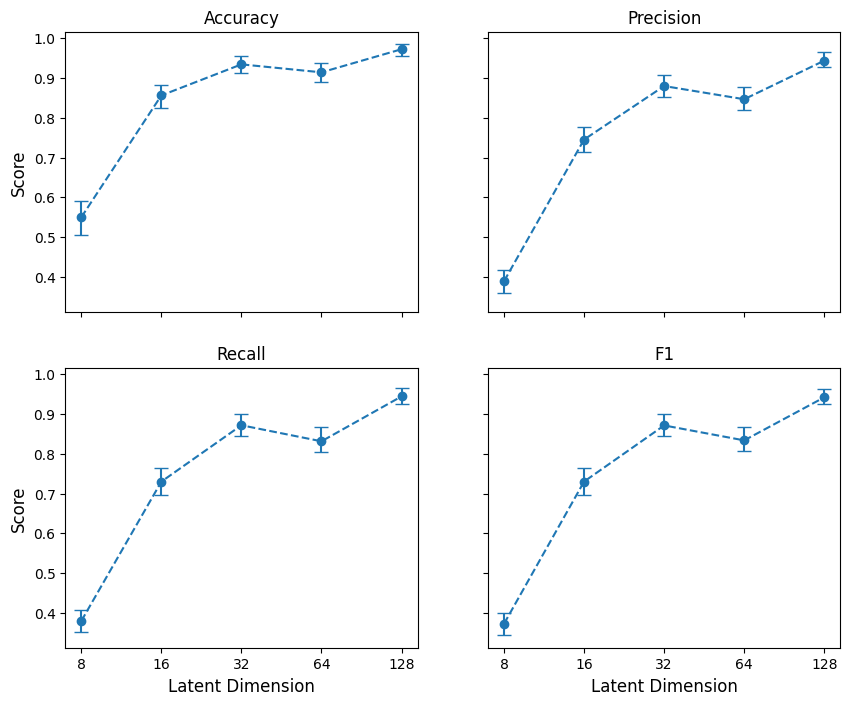

In [29]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), sharex=True, sharey=True)
x_labels = [s['latent_dim'] for s in scores_arr]
for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
    i, j = i // 2, i % 2
    mean_arr = [s[metric][0] for s in scores_arr]
    ci_lower_arr = [s[metric][1] for s in scores_arr]
    ci_upper_arr = [s[metric][2] for s in scores_arr]
    x_arr = np.arange(len(scores_arr))
    ax[i,j].errorbar(
        x_arr, mean_arr, 
        yerr=[np.array(mean_arr) - np.array(ci_lower_arr), np.array(ci_upper_arr) - np.array(mean_arr)], 
        fmt='o--', capsize=5
    )
    ax[i,j].set_title(metric.capitalize())
    ax[i,j].set_xticks(x_arr)
    ax[i,j].set_xticklabels(x_labels)
    if i == 1:
        ax[i,j].set_xlabel('Latent Dimension', fontsize=12)
    if j == 0:
        ax[i,j].set_ylabel('Score', fontsize=12)
fig.savefig('figures/latent_dim_scores.pdf', bbox_inches='tight')
plt.show()

In [165]:
def plot_metric_with_confidence_intervals(ax, scores_arr, metric, metric_label):

    # fig, ax = plt.subplots()
    idx_dict = {
        1: 0.5,
        3: 1.5,
        5: 2.5,
        10: 3.5,
    }
    color_dict = {
        'independent': 'tab:blue',
        'multidimensional': 'darkgoldenrod',
        'mixture': 'silver',
    }
    methods_in_legend = set()
    for s in scores_arr:
        mean = s[metric][0]
        ci_lower = s[metric][1]
        ci_upper = s[metric][2]
        y_idx = idx_dict[s['votes']]
        color = color_dict[s['method']]
        if s['method'] not in methods_in_legend:
            methods_in_legend.add(s['method'])
            ax.barh(y_idx, mean, xerr=[[mean - ci_lower], [ci_upper - mean]], capsize=3, label=s['method'], color=color, height=0.25)
        else:
            ax.barh(y_idx, mean, xerr=[[mean - ci_lower], [ci_upper - mean]], capsize=3, color=color, height=0.25)
        idx_dict[s['votes']] += 0.25

    ax.set_yticks(np.arange(0.75, 4, 1))
    ax.set_yticklabels([1, 3, 5, 10])
    ax.set_xlabel(metric_label, fontsize=12)
    ax.set_xlim(0.6, 0.95)

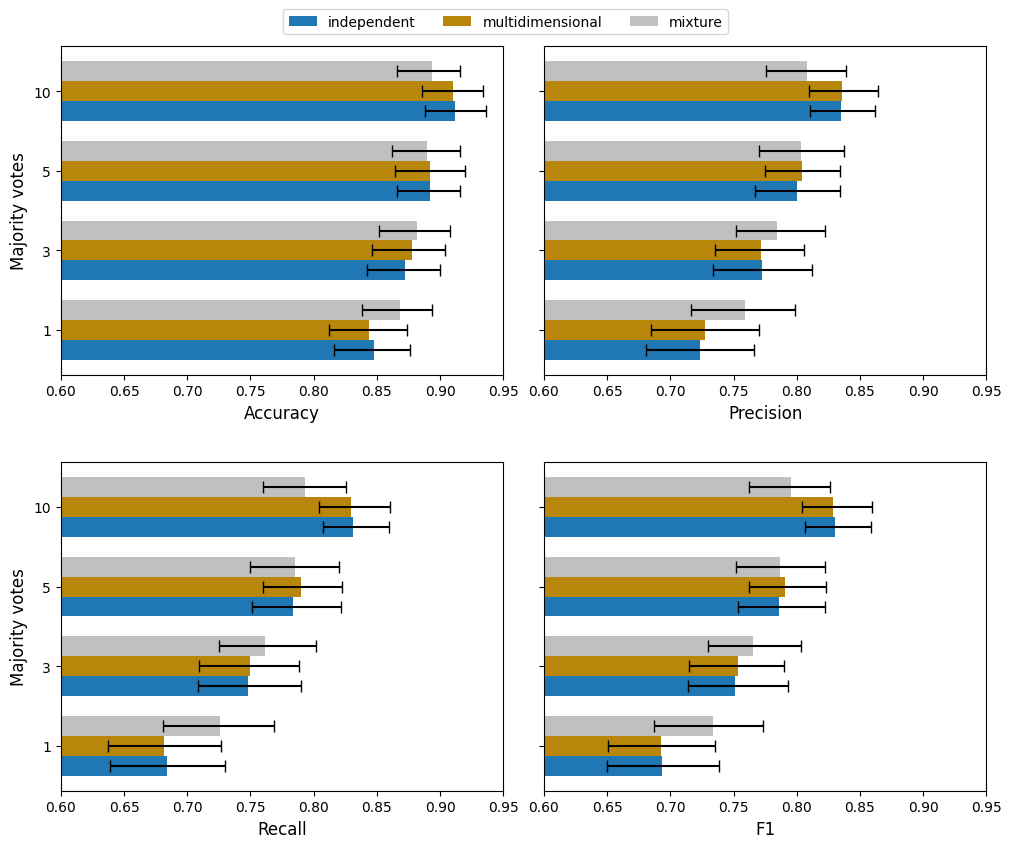

In [177]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True, sharey=True, gridspec_kw={'hspace': 0.1})
plot_metric_with_confidence_intervals(ax[0][0], scores_arr, 'accuracy', 'Accuracy')
plot_metric_with_confidence_intervals(ax[0][1], scores_arr, 'precision', 'Precision')
plot_metric_with_confidence_intervals(ax[1][0], scores_arr, 'recall', 'Recall')
plot_metric_with_confidence_intervals(ax[1][1], scores_arr, 'f1', 'F1')
ax[0,0].set_ylabel('Majority votes', fontsize=12)
ax[1,0].set_ylabel('Majority votes', fontsize=12)
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05))
fig.savefig('figures/dense_leaky_relu/metrics.pdf', bbox_inches='tight')
plt.show()